# Vorstellung - Mustererkennung Projekt: GeoLifeClef 2022 (Frankreich)

Projektquelle: [GeoLifeClef 2022 (Kaggle.com)](https://www.kaggle.com/competitions/geolifeclef-2022-lifeclef-2022-fgvc9/overview)

Übersichtsverzeichnis:
1. [Problemstellung](#Problemstellung)
1. Übersicht über die Daten
     1. [Datenbestand](#datenbestand)
     2. [Verteilung der Arten](Wie-sieht-die-Verteilung-der-Arten-aus?)
     3. [Daten der Arten](#Wie-sehen-die-Daten-der-Arten-aus?)
2. [Bewertungsfunktion](#Wie-werden-die-Vorhersagen-der-unterschiedlichen-Algorithmen-bewertet?)
3. [Vorhersagen mithilfe von k-Nächste Nachbarn Klassifikation](#K-Nächste-Nachbarn-Klassifikation)
4. [Vorhersagen mithilfe von Random Forest Classifier](#Vorhersagen-mit-Random-Forest-Classifier)

# Problemstellung

- Ziel: Lokalisierung von Pflanzen- und Tierarten
- Bsp.: gegeben ist Satellitenaufnahme --> Welche Art könnte hier beobachtet worden sein?
- 1,6 Millionen Observationen in Frankreich und USA
- 17.000 unterschiedliche Arten

Motivation:
- Verbesserung von Artbestimmungstools (automatische, semi-automatische) durch eine kleinere Vorhersageliste
- Förderung der Teilnahme von Bürgern (mihilfe von Apps)
- Beschleunigung der Artenbeobachtung --> bessere und qualititativere Datensätze

Organisation der Kaggle Challenge:

- [GeoLifeClef 2022 (Kaggle.com)](https://www.kaggle.com/competitions/geolifeclef-2022-lifeclef-2022-fgvc9/overview) von ImageCLEF organisiert
- weitere Challenges existieren z.B. BirdLifeCLEF

Einschränkung für unser Projekt:
- benutzt wird nur der Frankreich Datensatz  (wegen Speicherbedarf)

# Datenbestand

In [1]:
#Notwendiges Github-Repository für das Projekt:
!rm -rf GLC
!git clone https://github.com/maximiliense/GLC

Der Befehl "rm" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
fatal: destination path 'GLC' already exists and is not an empty directory.


- [GLC](https://github.com/maximiliense/GLC) enthält nützliche Funktionen (Laden der Daten, Auswertung, ...)
- wurde für die Kaggle-Challenge bereitgestellt

In [2]:
#Notwendige Imports für das Projekt
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [3]:
DATA_PATH = Path("./data/")

In [4]:
# 2 Datensäze: Trainingsdatensatz und Testdatensatz
df_obs = pd.read_csv(DATA_PATH / "observations" / "observations_fr_train.csv", sep=";", index_col="observation_id")
df_obs_test = pd.read_csv(DATA_PATH / "observations" / "observations_fr_test.csv", sep=";", index_col="observation_id")
# Wie sieht der Trainingsdatensatz aus?
df_obs.head()

,latitude,longitude,species_id,subset
observation_id,,,,
10561949,45.705116,1.424622,241,train
10131188,45.146973,6.416794,101,train
10799362,46.783695,-2.072855,700,train
10392536,48.604866,-2.825003,1456,train
10335049,48.815567,-0.161431,157,train


Trainingsdatensatz besteht aus:
- observation_id : Beobachtungs Id
- latitude : Breitengrad
- longitude : Längengrad
- species_id : Spezies Id (Art, die an dieser Stelle gesichtet wurde)
- subset : Training/Validierung

In [5]:
#Wie sieht der Testdatensatz aus?
df_obs_test.head()

,latitude,longitude
observation_id,,
10782781,43.601788,6.940195
10364138,46.241711,0.683586
10692017,45.181095,1.533459
10222322,46.938450,5.298678
10241950,45.017433,0.960736


Testdatensatz besteht nur aus Breiten- und Längengrad.

Da uns die tatsächlichen Beobachtungen für den Testdatensatz fehlen (Auswertung in der Kaggle-Competition), greifen wir auf den Validierungsdatensatz zurück und bewerten anhand diesem die Losungsansätze

In [6]:
#Datensätze aufgesplittet auf Training - Validierung - Test
obs_id_train = df_obs.index[df_obs["subset"] == "train"].values
obs_id_val = df_obs.index[df_obs["subset"] == "val"].values
obs_id_test = df_obs_test.index.values

n_obs = len(df_obs)
n_train = len(obs_id_train)
n_val = len(obs_id_val)
n_test = len(obs_id_test)

print(f'Datensatzgröße (Training & Validierung): {n_obs}')
print(f'Trainingsdatensatzgröße: {n_train} - {n_train / n_obs :.2%} der Beobachtungen')
print(f'Validierungsdatensatzgröße: {n_val} - {n_val / n_obs :.2%} der Beobachtungen')
print(f'Testdatensatzgröße: {n_test}')

Datensatzgröße (Training & Validierung): 671244
Trainingsdatensatzgröße: 656263 - 97.77% der Beobachtungen
Validierungsdatensatzgröße: 14981 - 2.23% der Beobachtungen
Testdatensatzgröße: 17295


## Wie sieht die Verteilung der Beobachtungen aus?

- Region Gironde enthält keine Datenpunkte 
- Grund ist uns nicht bekannt
- Datensatz basiert unter anderem auf [iNaturalist](https://www.inaturalist.org/)  (Dort sind Beobachtungen für Gironde da)

Text(0.5, 1.0, 'Verteilung der Beobachtungen in Frankreich)')

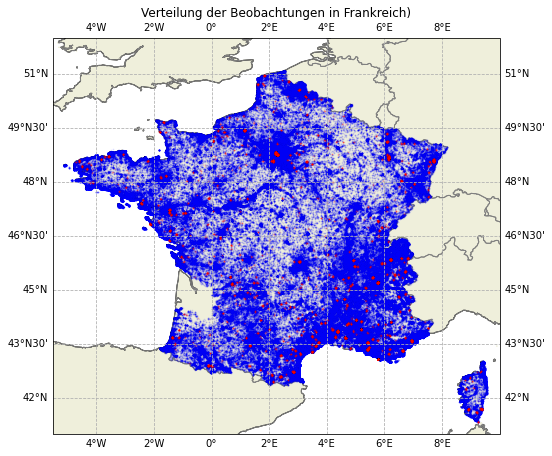

In [7]:
from GLC.plotting import plot_map

def plot_observations_distribution(ax, df_obs, df_obs_test, **kwargs):
    default_kwargs = {
        "zorder": 1,
        "alpha": 0.1,
        "s": 0.5
    }
    default_kwargs.update(kwargs)
    kwargs = default_kwargs
    
    ax.scatter(df_obs.longitude, df_obs.latitude, color="blue", **kwargs)
    ax.scatter(df_obs_test.longitude, df_obs_test.latitude, color="red", **kwargs)

fig = plt.figure(figsize=(8, 8))
ax = plot_map(region="fr")
plot_observations_distribution(ax, df_obs, df_obs_test)
ax.set_title("Verteilung der Beobachtungen in Frankreich)")

## Wie sieht die Verteilung der Arten aus?

Gesamtanzahl an Arten: 4858


(1, 1265.0)

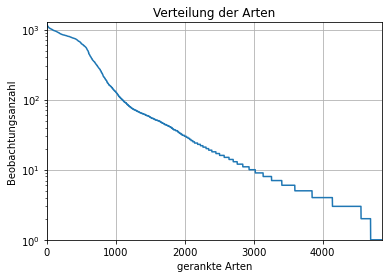

In [8]:
species_value_counts = df_obs["species_id"].value_counts()
print("Gesamtanzahl an Arten: {}".format(len(species_value_counts)))

fig = plt.figure()
ax = fig.gca()

x = np.arange(len(species_value_counts))
ax.plot(x, species_value_counts)

ax.set_yscale("log")

ax.set_xlabel("gerankte Arten")
ax.set_ylabel("Beobachtungsanzahl")
ax.set_title("Verteilung der Arten")

ax.grid()
ax.autoscale(tight=True)
ax.set_ylim(bottom=1)

## Wie sehen die Daten der Arten aus?

In [9]:
#Daten sind in species_details.csv gespeichert
df_species = pd.read_csv(DATA_PATH / "metadata" / "species_details.csv", sep=";")

print("Gesamtzahl an Arten: {}".format(len(df_species)))

print("\nAnzahl an Arten in jedem Reich:")
print(df_species.GBIF_kingdom_name.value_counts())

df_species.head()

Gesamtzahl an Arten: 17037

Anzahl an Arten in jedem Reich:
Plantae     9080
Animalia    7957
Name: GBIF_kingdom_name, dtype: int64


,species_id,GBIF_species_id,GBIF_species_name,GBIF_genus_name,GBIF_family_name,GBIF_kingdom_name
0,0,5356345,Laburnum anagyroides,Laburnum,Fabaceae,Plantae
1,1,2874515,Cucurbita maxima,Cucurbita,Cucurbitaceae,Plantae
2,2,2874569,Cucumis sativus,Cucumis,Cucurbitaceae,Plantae
3,3,3033363,Ranunculus acris,Ranunculus,Ranunculaceae,Plantae
4,4,3034830,Heracleum sphondylium,Heracleum,Apiaceae,Plantae


Begriffsklärung zum besseren Verständnis:
- spezies id: Id der Art
- GBIF: Global Biodiversity Information Facility (Informationen zu Biodiversität)
- GBIF_species_name: Name der Art
- GBIF_genus_name: Name der Gattung
- GBIF_family_name: Name der Familie
- GBIF_kingdom_name: Name des Reiches

weitere Informationen zur biologischen Systematik unter: https://de.wikipedia.org/wiki/Art_(Biologie) 

Einige Arten tauchen in Frankreich nicht auf, da der originale Kaggle-Datensatz auch die USA betrachtet.

## Wie werden die Vorhersagen der unterschiedlichen Algorithmen bewertet?

aus: https://www.kaggle.com/competitions/geolifeclef-2022-lifeclef-2022-fgvc9/overview/evaluation

Die Metrik ist die Top-30 Fehlerrate. Eine Beobachtung $i$ besitzt das label $y_{i}$ für die entsprechende ID der beobachteten Art. Für eine Beobachtung werden 30 IDs als Vorhersage ($\hat{y}_{i,1} , ..., \hat{y}_{i,30}$) eingereicht. 

Top-30 Fehlerrate berechnet sich durch die Formel:

$$ \text{Top-30 Fehlerrate} = \frac{1}{N} \sum \limits _{i=1} ^{N} e_{i} \text{   mit   } e_{i} = 
\begin{cases} 
1 & \text{if } \forall{k} \in {1,...,30}, \hat{y}_{i,k} \neq y_{i} \\ 
0 & \text{ansonsten}
\end{cases}
$$

Formeln zur Berechnung kommen aus dem [GLC](https://github.com/maximiliense/GLC), welches von der Erstellern der GeoLifeCLEF2022 bereitgestellt wurde:

In [10]:
from GLC.metrics import top_30_error_rate, top_k_error_rate_from_sets, predict_top_30_set
from GLC.submission import generate_submission_file

# K-Nächste Nachbarn Klassifikation

In [11]:
y_train = df_obs.loc[obs_id_train]["species_id"].values  #Id der Arten vom Trainingsdatensatz
y_val = df_obs.loc[obs_id_val]["species_id"].values # Id der Arten vom Validierungsdatensatz

X_train_loc = df_obs.loc[obs_id_train][['latitude','longitude']].values #Breitengrad, Längengrad vom Trainingsdatensatz
X_val_loc = df_obs.loc[obs_id_val][['latitude','longitude']].values # Breitengrad, Längengrad vom Validierungsdatensatz

In [12]:
PREDICTION_COUNT = 30

#Nehme die 30 besten Vorhersagen für eine Koordinate
def pred_coord(coord, y):
    arr = y[coord]
    u, count = np.unique(arr, return_counts=True)   # Artenanzahl in Nachbarn
    count_sort_ind = np.argsort(-count)             # Absteigende Sortierung
    return u[count_sort_ind][:PREDICTION_COUNT]     # Auswahl von Prediction Count

#Treffe Vorhersage für ein Array von Koordinaten
def predict_NN(model, X_loc, y):
    distances, indices = model.kneighbors(X_loc)
    predictions = []
    for i in range(len(indices)):
        predictions.append(pred_coord(indices[i],y))
    return np.array(predictions)

In [13]:
x_neighbors = []
y_scores = []

neighbors_dict = {}

NEIGHBORS_MIN = 100
NEIGHBORS_MAX = 1250

for k_neighbors in range(NEIGHBORS_MIN, NEIGHBORS_MAX, 50):
    nbrs = NearestNeighbors(n_neighbors=k_neighbors, algorithm='ball_tree').fit(X_train_loc)
    
    neighbors_dict[k_neighbors] = nbrs
    
    s_pred = predict_NN(nbrs, X_val_loc, y_train)
    score = top_k_error_rate_from_sets(y_val, s_pred)

    x_neighbors.append(k_neighbors)
    y_scores.append(score)

Text(0.5, 1.0, 'Top-30 Fehlerrate für unterschiedliche k (K-Nächste Nachbarn)')

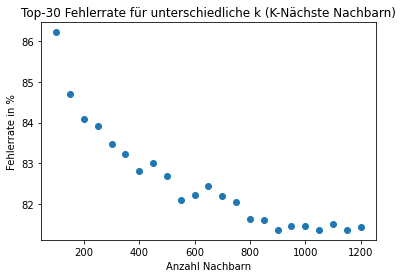

In [14]:
y_scores_percentage = list(map(lambda x: x*100, y_scores))

plt.scatter(x_neighbors, y_scores_percentage)

plt.xlabel("Anzahl Nachbarn")
plt.ylabel("Fehlerrate in %")
plt.title("Top-30 Fehlerrate für unterschiedliche k (K-Nächste Nachbarn)")

In [ ]:
pd_neighbors_error_rate = pd.DataFrame(zip(x_neighbors, y_scores_percentage), columns=["k", "Top-30 Fehlerrate in %"])
pd_neighbors_error_rate

In [ ]:
example_location = X_val_loc[100]  # Beispiel Koordinate
example_location = example_location.reshape(1, -1)

distances, indices = nbrs.kneighbors(example_location)  # Rückgabe der Nachbarn
species_ids = y_train[indices]  # Nachbarn als Arten

u, count = np.unique(species_ids, return_counts=True)  # Anzahl Vorkommen der Arten
u, count = np.unique(count, return_counts=True) # (Anzahl an Arten, die nur 1x als Nachbar vorkommen, ...)

print(count, u)
df_count_unique_neighbors = pd.DataFrame(count, u)
ax = df_count_unique_neighbors.plot.bar()
ax.set_xlabel("Häufigkeit Vorkommen einer Art als Nachbar")
ax.set_ylabel("Anzahl Arten")

- Bei 1200 beobachteten Nachbarn tauchen 272 Arten nur einmal auf
- 149 Arten treten zweimal auf
- Bei zu kleinem k passieren --> kaum Arten, die mehrmals auftreten (für Vorhersage nicht gut)
- Wenn k zwischen 800 - 1200 geringfügiger Unterschied (zwsichen 81,63 % - 81,36%)

## Vergleich: k=100 und k=800:

In [ ]:
nbrs_100 = NearestNeighbors(n_neighbors=100, algorithm='ball_tree').fit(X_train_loc)
distances_100, indices_100 = nbrs_100.kneighbors(X_train_loc)

In [ ]:
nbrs_800 = NearestNeighbors(n_neighbors=800, algorithm='ball_tree').fit(X_train_loc)
distances_800, indices_800 = nbrs_800.kneighbors(X_train_loc)

In [71]:
example_location = X_val_loc[100]  # Beispiel Koordinate
example_location = example_location.reshape(1, -1)

distances_100, indices_100 = neighbors_dict[100].kneighbors(example_location)
distances_1200, indices_1200 = neighbors_dict[1200].kneighbors(example_location)

In [73]:
loc_100 = X_train_loc[indices_100]
loc_100[0]
df_loc_100 = pd.DataFrame(loc_100[0], columns=["longitude", "latitude"])
df_example_loc_100 = pd.DataFrame(example_location, columns=["longitude", "latitude"])

loc_1200 = X_train_loc[indices_1200]
df_loc_1200 = pd.DataFrame(loc_1200[0], columns=["longitude", "latitude"])

In [80]:
lat_min = df_loc_1200["latitude"].min() - 0.2
lat_max = df_loc_1200["latitude"].max() + 0.2

lon_min = df_loc_1200["longitude"].min() - 0.2
lon_max = df_loc_1200["longitude"].max() + 0.2

Text(0.5, 1.0, '100 Nachbarn von Validierungsset[100]')

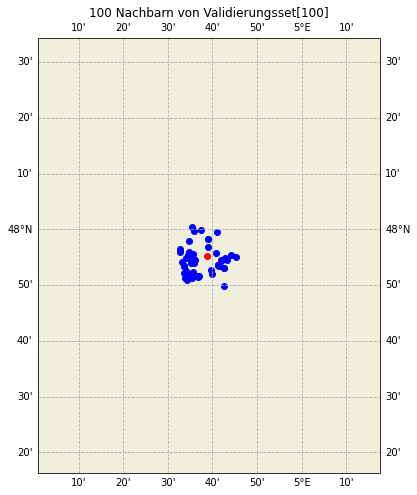

In [85]:
fig = plt.figure(figsize=(8, 8))
ax = plot_map(extent = [lat_min, lat_max, lon_min, lon_max])
ax.scatter(df_loc_100.latitude, df_loc_100.longitude, color="blue")
ax.scatter(df_example_loc_100.latitude, df_example_loc_100.longitude, color="red")
ax.set_title("100 Nachbarn von Validierungsset[100]")

Text(0.5, 1.0, '1200 Nachbarn von Validierungsset[100]')

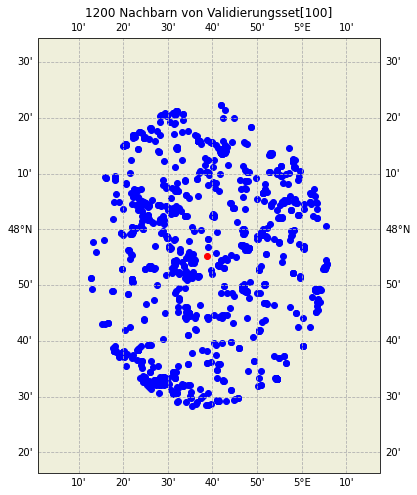

In [86]:
fig = plt.figure(figsize=(8, 8))
ax = plot_map(extent = [lat_min, lat_max, lon_min, lon_max])
ax.scatter(df_loc_1200.latitude, df_loc_1200.longitude, color="blue")
ax.scatter(df_example_loc_100.latitude, df_example_loc_100.longitude, color="red")
ax.set_title("1200 Nachbarn von Validierungsset[100]")

Text(0.5, 1.0, '100 Nachbarn von Validierungsset[100]')

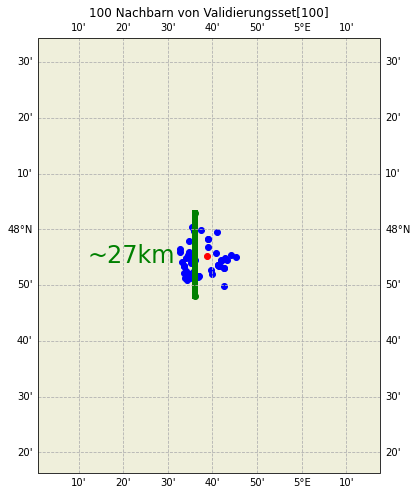

In [125]:
fig = plt.figure(figsize=(8, 8))
ax = plot_map(extent = [lat_min, lat_max, lon_min, lon_max])
ax.scatter(df_loc_100.latitude, df_loc_100.longitude, color="blue")
ax.scatter(df_example_loc_100.latitude, df_example_loc_100.longitude, color="red")
ax.plot([4.60, 4.60],[47.8, 48.05], 'go-', linewidth=6)
ax.text(4.2,47.9,"~27km", size=24, color="green")
ax.set_title("100 Nachbarn von Validierungsset[100]")

Text(0.5, 1.0, '1200 Nachbarn von Validierungsset[100]')

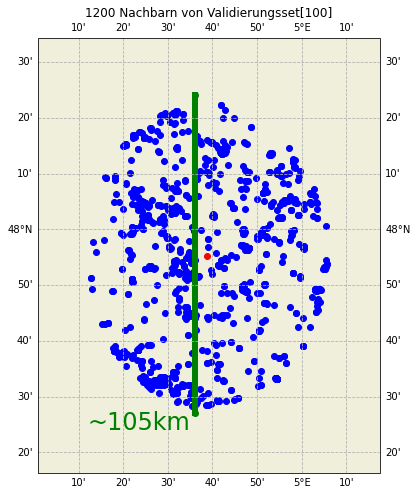

In [127]:
fig = plt.figure(figsize=(8, 8))
ax = plot_map(extent = [lat_min, lat_max, lon_min, lon_max])
ax.scatter(df_loc_1200.latitude, df_loc_1200.longitude, color="blue")
ax.scatter(df_example_loc_100.latitude, df_example_loc_100.longitude, color="red")
ax.plot([4.60, 4.60],[47.45, 48.4], 'go-', linewidth=6)
ax.text(4.2,47.4,"~105km", size=24, color="green")
ax.set_title("1200 Nachbarn von Validierungsset[100]")


In [165]:
df_obs.head()

,latitude,longitude,species_id,subset
observation_id,,,,
10561949,45.705116,1.424622,241,train
10131188,45.146973,6.416794,101,train
10799362,46.783695,-2.072855,700,train
10392536,48.604866,-2.825003,1456,train
10335049,48.815567,-0.161431,157,train


In [172]:
validating_data = df_obs.query('subset == "val"')

In [174]:
validating_data

,latitude,longitude,species_id,subset
observation_id,,,,
10297014,46.927032,4.798213,11,val
10610548,46.865562,4.914852,467,val
10545927,43.972557,4.904952,364,val
10267693,44.429108,4.179069,805,val
10158346,47.187496,-0.312558,348,val
...,...,...,...,...
10647683,43.250824,5.623314,136,val
10354107,44.816044,5.681046,242,val
10440157,49.622234,3.310203,940,val


Text(0.5, 1.0, 'Verteilung der Beobachtungen in Frankreich)')

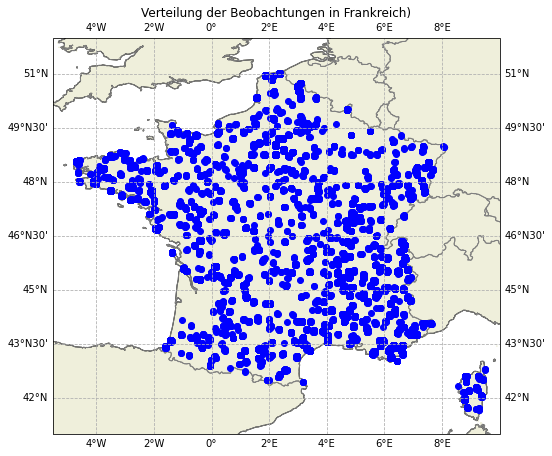

In [175]:
fig = plt.figure(figsize=(8, 8))
ax = plot_map(region="fr")
ax.scatter(validating_data.longitude, validating_data.latitude, color="blue")
ax.set_title("Verteilung der Beobachtungen in Frankreich)")

In [177]:
df_obs.query('subset == "val" and latitude < 42.8 and latitude > 42.0and longitude > 3 and longitude < 3.8')

,latitude,longitude,species_id,subset
observation_id,,,,
10483118,42.434757,3.159651,369,val
10598635,42.434235,3.156994,668,val
10433153,42.435379,3.168013,1599,val
10534873,42.435276,3.159444,234,val


In [180]:
location_south = df_obs.loc[10483118][['latitude','longitude']].values

In [181]:
example_location = location_south.reshape(1, -1)

distances_1200, indices_1200 = neighbors_dict[1200].kneighbors(example_location)

In [182]:
loc_1200 = X_train_loc[indices_1200]
df_loc_1200 = pd.DataFrame(loc_1200[0], columns=["longitude", "latitude"])

In [185]:
lat_min = df_loc_1200["latitude"].min() - 0.2
lat_max = df_loc_1200["latitude"].max() + 0.2

lon_min = df_loc_1200["longitude"].min() - 0.2
lon_max = df_loc_1200["longitude"].max() + 0.2

In [194]:
location_south = location_south.reshape(1, -1)
df_loc_south = pd.DataFrame(location_south, columns=["longitude", "latitude"])
df_loc_south

,longitude,latitude
0,42.434757,3.159651


Text(0.5, 1.0, '1200 Nachbarn von Validierungsset[100]')

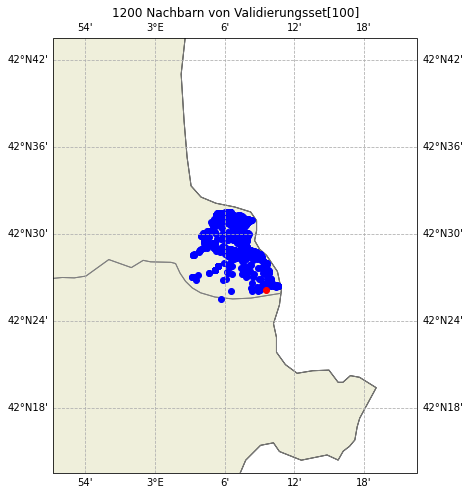

In [195]:
fig = plt.figure(figsize=(8, 8))
ax = plot_map(extent = [lat_min, lat_max, lon_min, lon_max])
ax.scatter(df_loc_1200.latitude, df_loc_1200.longitude, color="blue")
ax.scatter(df_loc_south.latitude, df_loc_south.longitude, color="red")
ax.set_title("1200 Nachbarn von Validierungsset[100]")

Text(0.5, 1.0, '1200 Nachbarn von Validierungsset[100]')

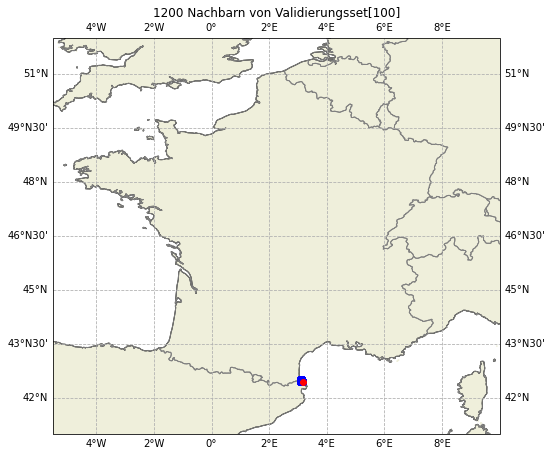

In [196]:
fig = plt.figure(figsize=(8, 8))
ax = plot_map(region="fr")
ax.scatter(df_loc_1200.latitude, df_loc_1200.longitude, color="blue")
ax.scatter(df_loc_south.latitude, df_loc_south.longitude, color="red")
ax.set_title("1200 Nachbarn von Validierungsset[100]")